In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### fitting
# import statsmodels.api as sm

### PCA
# from sklearn.decomposition import PCA, KernelPCA

### Model generation
import itertools as it

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# ### Functions used in this code
import age_functions as afunc

### Stuff Writtten by A Really Cool Professor
# import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [48]:
###################
### Import Data ###
###################

# parsec
''' Ages used 8 to 10.1 steps 0.15'''
# ''' Metallicity used -2.6 to 0.1 steps 0.099'''

# parsecall = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3_3.dat', \
#                     format='basic', delimiter='\s')
parsec = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz')
rgb = np.where(parsec['label']==3)
parsec = parsec[rgb]


# lmc
lmc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-100.0)&(lmc['LOGG']>=0.0)&(lmc['M_H_ERR']>-100.0)&
               (lmc['C_FE']>-100.0)&(lmc['N_FE']>-100.0))
lmc = lmc[cln]

# Diane Feuillet
pdfout = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/LMC_DR16_all_PDF.fits.gz', 1)
_, r13_ind, pdfout_ind = np.intersect1d(lmc['APOGEE_ID'],pdfout['OBJ'],return_indices=True)

In [39]:
###############################
### Some Calcuations Needed ###
###############################

### Convert RA DEC to MS L B
c_icrs = SkyCoord(ra=lmc['RA']*u.degree, dec=lmc['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

for i in range(len(ms_lg)):
    if ms_lg[i]-360<-180:
        ms_lg[i] += 360.0

### Get Solar Fractions
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

In [3]:
### Setup 
# data = np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T

# ### Determine Number of factors
# pca = PCA(n_components=4).fit(data)#_rescaled)
# plt.rcParams["figure.figsize"] = (12,6)

# fig, ax = plt.subplots()

# y = np.cumsum(pca.explained_variance_ratio_)
# xi = np.arange(1, len(pca.explained_variance_ratio_)+1, step=1)

# plt.ylim(0.0,1.1)
# plt.plot(xi, y, marker='o', linestyle='--', color='b')

# plt.xlabel('Number of Components')
# plt.xticks(np.arange(0, 5, step=1)) #change from 0-based array index to 1-based human-readable label
# plt.ylabel('Cumulative variance (%)')
# plt.title('The number of components needed to explain variance')

# plt.axhline(y=0.99, color='r', linestyle='-')
# plt.text(0.5, 0.85, '99% cut-off threshold', color = 'red', fontsize=16)

# ax.grid(axis='x')
# plt.show()

In [95]:
# create new variables

# linear terms
x0 = data[:,0]
x1 = data[:,1]
x2 = data[:,2]
x3 = data[:,3]

# linear int
x01 = np.multiply(x0,x1)
x02 = np.multiply(x0,x2)
x03 = np.multiply(x0,x3)
x12 = np.multiply(x1,x2)
x13 = np.multiply(x1,x3)
x23 = np.multiply(x2,x3)

# squares
x0sq = x0**2
x1sq = x1**2
x2sq = x2**2
x3sq = x3**2

# cubes
x0cu = x0**3
x1cu = x1**3
x2cu = x2**3
x3cu = x3**3

In [97]:
#find all possible models
models = []
models_str = []

all_var_str = ['x0','x1','x2','x3','x01','x02','x03','x12','x13','x23','x0sq','x1sq','x2sq','x3sq','x0cu','x1cu',
               'x2cu','x3cu']
all_var = [x0,x1,x2,x3,x01,x02,x03,x12,x13,x23,x0sq,x1sq,x2sq,x3sq,x0cu,x1cu,x2cu,x3cu]

for i in range(4, len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
        
models = np.array(models)
models_str = np.array(models_str)

261156

In [ ]:
# ### Fit All Models

# import statsmodels.api as sm 

# all_params = []
# summaries = []
# max_resid = []
# mads = []
# resids = []
# predict = []
# ll = []
# for i in tqdm_notebook(range(len(models)),desc='Done?'):
#     pmodl = np.array(models[i]).T
#     pmodl = sm.add_constant(pmodl)
#     model = sm.OLS(parsec['logAge'],pmodl).fit()
#     summaries.append(model.summary())
#     predictions = model.predict(pmodl)
#     predict.append(predictions)
#     residual = predictions - parsec['logAge']
#     resids.append(residual)
#     all_params.append(np.asarray(model.params))
#     max_resid.append(np.max(np.absolute(residual)))
#     mads.append(afunc.mad(residual))
#     ll.append(model.llf)

In [67]:
# test = models[0]+ np.ones(len(models[0]))
# test
test = models[0]+(np.ones(len(models[0])),)
test

(array([3.4681, 3.5066, 3.508 , ..., 3.6211, 3.6267, 3.7239]), array([1.]))

In [68]:
models[]

(array([10.312,  9.595,  9.57 , ..., -5.68 , -5.656, 13.88 ]),)

In [23]:
p = []
for i in range(19):
    p.append('b{}'.format(i))
print(p)

['b0', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11', 'b12', 'b13', 'b14', 'b15', 'b16', 'b17', 'b18']


In [41]:
from sko.GA import GA

data = np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T

def agemodl(b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,x0,x1,x2,x3):
    '''
    General model for ages upto 3rd order in logTe, Ksmag, MH, logg with simple interactions of linear terms. 
    
    Parameters:
    -----
        b: array-like object of model parameters with length 19
        x: array of independent variables (logTe, Ksmag, [Fe/H], logg)
    
    Returns:
    ----
        y: age
    '''
    y = (b0+
         b1*x0+b2*x1+b3*x2+b4*x3+ 
         b5*np.multiply(x0,x1)+b6*np.multiply(x0,x2)+b7*np.multiply(x0,x3)+
         b8*np.multiply(x1,x2)+b9*np.multiply(x1,x3)+
         b10*np.multiply(x2,x3)+
         b11*np.square(x0)+b12*np.square(x1)+b13*np.square(x2)+b14*np.square(x3)+
         b15*np.power(x0,3)+b16*np.power(x1,3)+b17*np.power(x2,3)+b18*np.power(x3,3))
    return y
    
def objective(b):
    b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18 = b
    residuals = np.square(agemodl(b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,data[:,0],data[:,1],data[:,2],data[:,3]) - parsec['logAge']).sum()
    return residuals

### Magellan
# ga = GA(func=objective, n_dim=19, size_pop=20, max_iter=10,lb=[-10] * 19, ub=[2] * 19)

# best_params, residuals = ga.run()
# print('best_x:', best_params, '\n', 'best_y:', residuals)

In [ ]:
def model(b,x):
    len()

In [98]:
def find_ages(x0,x1,x2,x3):
#     b = [-7.83650919,-4.69796477,4.10136809,-3.5465118,-0.46985869,-0.2250934,5.04455863,2.60043097,0.94530139,
#          2.09096123,-5.59351197,-4.73225472,2.74943617,1.2755837,-2.03544286,1.84732032,0.28125752,0.29453095,
#          0.06657135]
    
    b = [2.45778513,0.52052256,2.4978969,-1.15990986,-0.18349242,0.1225308,0.77691783,0.24161901,0.19341815,
         0.27583394,-2.03918298,0.53548347,1.07101683,-3.31065779,-1.73420024,0.05174946,0.10317881,-1.17549923,
         0.35648126]
    
    y = (b[0]+
         b[1]*x0+b[2]*x1+b[3]*x2+b[4]*x3+ 
         b[5]*np.multiply(x0,x1)+b[6]*np.multiply(x0,x2)+b[7]*np.multiply(x0,x3)+
         b[8]*np.multiply(x1,x2)+b[9]*np.multiply(x1,x3)+
         b[10]*np.multiply(x2,x3)+
         b[11]*np.square(x0)+b[12]*np.square(x1)+b[13]*np.square(x2)+b[14]*np.square(x3)+
         b[15]*np.power(x0,3)+b[16]*np.power(x1,3)+b[17]*np.power(x2,3)+b[18]*np.power(x3,3))
    return y


In [32]:
a = [9.38631710e+00,4.57009017e-02,-5.98198867e-02,-2.99642242e+00,1.86921027e-02,-4.51165023e-02,1.10829968e-01,
 -5.93377185e-03,2.51457473e-02,7.98522275e-01,2.26643514e-02,4.00941011e-01]
b = [9.38631710e+00,4.57009017e-02,-5.98198867e-02,-2.99642242e+00,1.86921027e-02,-4.51165023e-02,
          1.10829968e-01,-5.93377185e-03,2.51457473e-02,7.98522275e-01,2.26643514e-02,4.00941011e-01]

a==b

True

<font size='48'>
    <b>
        CALCULATE AGES
    </b>
</font>

In [33]:
### Uncertainty Functions

def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

In [99]:
age_dist = []

for i in tqdm_notebook(range(len(lmc)),desc='Done?'):
    # temperature
    teff = lmc['TEFF'][i]
    teff_err = lmc['TEFF_ERR'][i]
    
    # photometry 
    ra = lmc['RA'][i]
    dec = lmc['DEC'][i]
    ks = lmc['K'][i]
    ks_err = lmc['K_ERR'][i]
    ak = lmc['AK_TARG'][i]
    
    # abundances
    mh = lmc['M_H'][i]
    mh_err = lmc['M_H_ERR'][i]
    cfe = lmc['C_FE'][i]
    cfe_err = lmc['C_FE_ERR'][i]
    nfe = lmc['N_FE'][i]
    nfe_err = lmc['N_FE_ERR'][i]
    feh = lmc['FE_H'][i]
    feh_err = lmc['FE_H_ERR'][i]
    
    # surface gravity
    lgg = lmc['LOGG'][i]
    lgg_err = lmc['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err)
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = new

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2],zs[l][3]))
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in tqdm_notebook(range(len(age_dist))):
    devs.append(afunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))

In [46]:
# print(np.where(parages<=np.log10(0.5*10**9)))
# print(np.log10(0.5*10**9))
# plt.hist(parages,range=(8,12))

In [103]:
np.log10((3.26156/69.8*1000*299792458))

10.146390652563621

Text(0, 0.5, 'Bayesian')

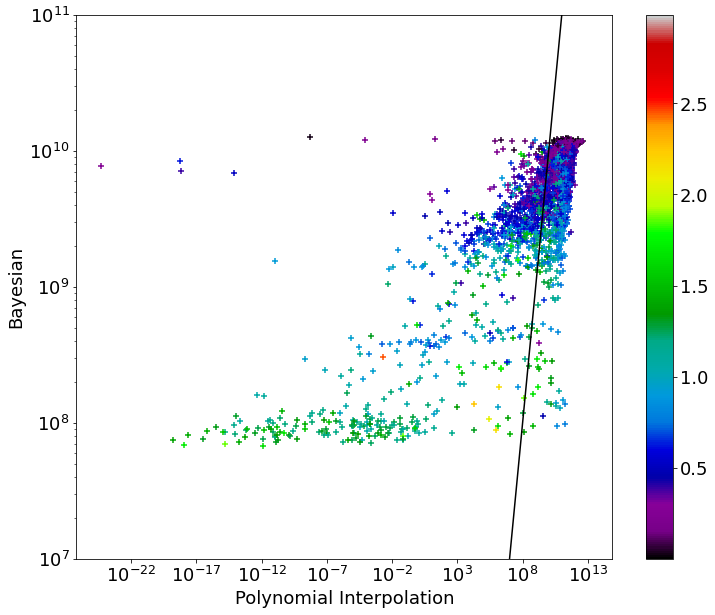

In [106]:
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(parages)[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=lmc['LOGG'][r13_ind],
                marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**7,10**11)
# plt.xlim(10**7,10**13)

plt.xlabel(r'Polynomial Interpolation')
plt.ylabel(r'Bayesian')

In [32]:
# plt.hist(10**pdfout['P_MEAN'][pdfout_ind])

In [33]:
# plt.hist(10**np.asarray(parages)[r13_ind])

In [34]:
# plt.hist(age_dist[100])

In [35]:
cat = Table()
col_id = Column(np.asarray(r13['APOGEE_ID']),name='APOGEE_ID')
col_age = Column(np.asarray(parages),name='AGE')
col_dev = Column(np.asarray(devs),name='AGE_ERR')
col_dist = Column(np.asarray(age_dist),name='DIST')

cat.add_column(col_id)
cat.add_column(col_age)
cat.add_column(col_dev)
cat.add_column(col_dist)

# cat.write('TEST_pca_ols_ages.fits',format='fits')#,overwrite=True)
# cat.write('TEST_pca_ols_ll.fits',format='fits',overwrite=True)

In [36]:
# ### Find all models

# #transform data to new basis
# # new_data = PCA(n_components=3).fit(data).transform(data)

# #create new variables

# # linear terms
# x1 = parsec['logTe'] #new_data[:,0]
# x2 = parsec['Ksmag'] #new_data[:,1]
# x3 = parsec['MH'] #new_data[:,2]
# x4 = parsec['logg']

# # linear int
# x12 = np.multiply(x1,x2)
# x13 = np.multiply(x1,x3)
# x14 = np.multiply(x1,x4)

# x23 = np.multiply(x2,x3)
# x24 = np.multiply(x2,x4)

# x34 = np.multiply(x3,x4)


# # squares
# x1sq = x1**2
# x2sq = x2**2
# x3sq = x3**2
# x4sq = x4**2

# # cubes
# # x1cu = x1**3
# # x2cu = x2**3
# # x3cu = x3**3


# #find all possible models
# models = []
# models_str = []

# all_var_str = ['x1','x2','x3','x4','x12','x13','x23','x24','x34','x1sq','x2sq','x3sq','x4sq']
# all_var = [x1,x2,x3,x4,x12,x13,x23,x24,x34,x1sq,x2sq,x3sq,x4sq]

# for i in range(1,len(all_var)+1):
#     for subset in it.combinations(all_var,i):
#         models.append(subset)
#     for subset_str in it.combinations(all_var_str,i):
#         models_str.append(np.array(subset_str))
        
# models = np.array(models)
# models_str = np.array(models_str)

# ### Fit All Models

# import statsmodels.api as sm 

# all_params = []
# summaries = []
# max_resid = []
# mads = []
# resids = []
# predict = []
# ll = []
# for i in tqdm_notebook(range(len(models)),desc='Done?'):
#     pmodl = np.array(models[i]).T
#     pmodl = sm.add_constant(pmodl)
#     model = sm.OLS(parsec['logAge'],pmodl).fit()
#     summaries.append(model.summary())
#     predictions = model.predict(pmodl)
#     predict.append(predictions)
#     residual = predictions - parsec['logAge']
#     resids.append(residual)
#     all_params.append(np.asarray(model.params))
#     max_resid.append(np.max(np.absolute(residual)))
#     mads.append(afunc.mad(residual))
#     ll.append(model.llf)

In [37]:
# print(summaries[np.asarray(ll).argmax()])
# print(all_params[np.asarray(ll).argmax()])
# print(models_str[np.asarray(ll).argmax()])


In [38]:
# print(summaries[np.asarray(mads).argmin()])
# print(all_params[np.asarray(mads).argmin()])
# print(models_str[np.asarray(mads).argmin()])

In [39]:
# def find_ages(z1,z2,z3,z4):
# #     p = [9.77943559e+02,-5.25226935e+02,1.24426878e+01,-1.71063906e+01,-3.33360237e+00,4.80431454e+00,
# #          -6.62127176e-02,3.89523313e-01,-8.75802774e-02,7.16174805e+01,-3.29702782e-02,1.69804627e-01,
# #          -5.39563301e-01]
# #     ages = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
# #             p[7]*np.multiply(z2,z4)+p[8]*np.multiply(z3,z4)+p[9]*(z1**2)+p[10]*(z2**2)+p[11]*(z3**2)+
# #             p[12]*(z4**2))

# #     p = [9.80851387e+02,-5.24981733e+02,1.26388036e+01,-1.48527724e+01,-3.38508869e+00,4.09636862e+00,
# #          -8.83269488e-02,3.70451942e-01,7.13126367e+01,-3.11197530e-02,1.35549807e-01,-5.05326057e-01]
# #     ages = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
# #             p[7]*np.multiply(z2,z4)+p[8]*(z1**2)+p[9]*(z2**2)+p[10]*(z3**2)+p[11]*(z4**2))

#     p = [1.62773106e+02,-7.74432139e+01,5.79432496e+00,-8.21554113e-01,-6.31502225e+00,-8.53547492e-01,
#          3.03422107e-01,-1.21805077e-02,-4.28300766e-01,-1.54961212e-03,1.08410088e+01,1.01740575e-01,
#          7.55430356e-02,4.96225871e-01]
#     ages = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*z4+p[5]*np.multiply(z1,z2)+p[6]*np.multiply(z1,z3)+
#             p[7]*np.multiply(z2,z3)+p[8]*np.multiply(z2,z4)+p[9]*np.multiply(z3,z4)+p[10]*(z1**2)+p[11]*(z2**2)+
#             p[12]*(z3**3)+p[13]*(z4**2))
    
# #     p = [1.17993328e+02,-5.31336187e+01,5.45824048e+00,2.99452735e-01,-6.47520602e+00,-7.47386878e-01,
# #          -8.83982229e-03,-4.45546306e-01,7.56108649e+00,1.04148096e-01,7.17546427e-02,5.20605161e-01]
# #     ages = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*z4+p[5]*np.multiply(z1,z2)+p[6]*np.multiply(z1,z3)+
# #             p[7]*np.multiply(z2,z3)+p[8]*np.multiply(z2,z4)+p[8]*(z1**2)+p[9]*(z2**2)+p[10]*(z3**2)+p[11]*(z4**2))
#     return ages

In [40]:
# len(all_params[np.asarray(ll).argmax()])
# len(models_str[np.asarray(ll).argmax()])

In [41]:
# age_dist = []

# pca_transform = PCA(n_components=3).fit(data)

# for i in tqdm_notebook(range(len(r13)),desc='Done?'):
#     # temperature
#     teff = r13['TEFF'][i]
#     teff_err = r13['TEFF_ERR'][i]
    
#     # photometry 
#     ra = r13['RA'][i]
#     dec = r13['DEC'][i]
#     ks = r13['K'][i]
#     ks_err = r13['K_ERR'][i]
#     ak = r13['AK_TARG'][i]
    
#     # abundances
#     mh = r13['M_H'][i]
#     mh_err = r13['M_H_ERR'][i]
#     cfe = r13['C_FE'][i]
#     cfe_err = r13['C_FE_ERR'][i]
#     nfe = r13['N_FE'][i]
#     nfe_err = r13['N_FE_ERR'][i]
#     feh = r13['FE_H'][i]
#     feh_err = r13['FE_H_ERR'][i]
    
#     # surface gravity
#     lgg = r13['LOGG'][i]
#     lgg_err = r13['LOGG_ERR'][i]
    
#     noise_ages = []
#     new = []
#     for j in range(100):
       
#         # calculate noisy temperature
#         teff_new = add_noise(teff,teff_err) 
#         lgteff_new = np.log10(teff_new)
    
#         # Calculate noisy K magnitude
#         _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
#         ks_new = add_noise(ks,ks_err)
            
#         absK_new = afunc.absmag(ks_new,dist) - ak
            
#         # Calculate noisy Salaris correction
        
#         x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
#                                  add_noise(feh,feh_err)-add_noise(mh,mh_err))
#         x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
#                                  add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
#         ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
#         mh_new = add_noise(mh,mh_err)
        
#         # Calculate noisy surface gravity
#         lgg_new = add_noise(lgg,lgg_err)
            
#         # calculate noisy age
# #         new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
# #     zs = pca_transform.transform(np.asarray(np.squeeze(new)))

# #     for l in range(len(zs)):
#         noise_ages.append(find_ages(lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new))
    
#     age_dist.append(noise_ages)

# parages = [] 
# devs = []
# for k in tqdm_notebook(range(len(age_dist))):
#     devs.append(afunc.mad(age_dist[k]))
#     parages.append(np.median(age_dist[k]))

In [42]:
# plt.hist(parages)

In [43]:
# plt.figure(figsize=[12,10])
# plt.scatter(10**np.asarray(parages)[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
#                 marker='+',cmap='nipy_spectral')
# plt.colorbar()
# plt.xscale('log')
# plt.yscale('log')
# plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
# plt.ylim(10**7,10**11)
# plt.xlim(10**7,10**13)